# COMBINE ALPHAS INTO A PORTFOLIO

# Summary

- Goal
- Import libraries
- Import data
    - Import daily returns of each backtested alpha
    - Import benchmark's data (SPY)
- Check the performance of the first alpha
- Check the performance of a portfolio of both alpha
    - Concatenate the returns of each alpha into a single dataframe
    - Check the correlation of the returns of the strategies
    - Weight the returns of each alpha using equal weights
    - Sum the weighted returns
    - Performances metrics of the portfolio
    - Equity curve of the portfolio vs each individual alpha
    - Equity curve of the portfolio vs benchmark (Buy&Hold SPY ETF)
    - Daily returns of the portfolio
- Conclusion

# Goal

Combine the momentum strategy we have backtested in the precedent notebook with another mean reversion strategy (whose backtest is not available on this repository) to see if we can benefit from diversification.



# Imports libraries

In [1]:
# For data handling
import pandas as pd
import numpy as np

# To ignore warnings
import warnings
warnings.filterwarnings('ignore')

# For datetime manipulation
import datetime as dt

# For plotting
import matplotlib.pyplot as plt
import kaleido

# Import data

## Import daily returns of each backtested alpha

In [2]:
# Paths toward unrealized returns of each strategy
path_rets = '/Users/utilisateur/Desktop/Victor/Goals/1_Trading/Labo/Python/Strategies/raw_python/A_Work/pyqstrat/'

# Import unrealized returns of each strategy
a1 = pd.read_csv(path_rets+'rets1_alpha1.csv', index_col=0, dayfirst=True)
a2 = pd.read_csv(path_rets+'rets1_alpha2.csv', index_col=0, dayfirst=True)

a1 = a1.dropna()
a2 = a2.dropna()

## Import benchmark's data (SPY)

In [3]:
path1 = '/Users/utilisateur/Desktop/Victor/Goals/1_Trading/Labo/Python/Datas/Datas ohlcv/Daily/SPY.csv'

# Read the csv file and convert the index into a datetime index
bench = pd.read_csv(path1, parse_dates=['Date'], index_col='Date')
bench.index = pd.to_datetime(bench.index, format='%d-%m-%Y')
#bench = bench[1:-3]
# Calculate daily open to open returns of the benchmark
bench['bench_O_to_O_rets'] = (bench['Open'].pct_change()).shift(-1)
bench.dropna(inplace=True)

bench_rets = np.array(bench['bench_O_to_O_rets'])
bench_rets

array([ 0.00772479,  0.00848326, -0.01043882, ...,  0.00209172,
        0.01256999,  0.00335269])

# Check the performance of the first alpha

In [4]:
def performances(unr_portfolio, unr_bench):

    # Lenght backtest in years
    years = len(unr_portfolio) / 252
    
    # Total return (simple)
    total_return_simple = np.nancumsum(unr_portfolio)[-1]
    
    # Average annual return (simple returns)
    annual_return_simple = np.nanmean(unr_portfolio) * 252
    

    # Sharpe ratio
    sharpe = np.nanmean(unr_portfolio) / np.nanstd(unr_portfolio)*16

    # Maximum drawdown with simple returns
    cum_simple_rets = np.nancumsum(unr_portfolio)
    cum_max_rets = np.maximum.accumulate(cum_simple_rets)
    drawdowns = cum_max_rets - cum_simple_rets
    max_drawdown_simple = np.max(drawdowns)
    
    # Calmar ratio with simple returns
    calmar_simple = annual_return_simple / max_drawdown_simple
    
    
    # Regress backtest returns against benchmark returns
    m = np.polyfit(unr_bench,unr_portfolio,1)
    xx = np.linspace(min(unr_bench),max(unr_bench),200)
    yy = np.polyval(m,xx)

    # Profit factor
    PF_portfolio = (unr_portfolio[unr_portfolio > 0].sum() / unr_portfolio[unr_portfolio < 0].sum()) * (-1)

    # Max win & max loss in a day
    max_win_in_one_day = unr_portfolio.max()
    max_loss_in_one_day = unr_portfolio.min()
    
    '''
    # Average position size
    pos2 = pos.copy()
    position_size = pos2.sum(axis=1)
    avg_position_size = position_size.mean() / len(pos2.columns[:-1])
    '''
    
    
    
    print('Lenght backtest in years:            ', int(years))
    print('Total return simple [%]:             ', total_return_simple.round(3)*100)
    print('')
    print('Annual return simple [%]:            ', annual_return_simple.round(3)*100)
    print('')
    print('Sharpe:                              ', sharpe.round(2))
    print('')
    print('Max drawdown simple [%]:             ', max_drawdown_simple.round(3)*100)
    print('')
    print('Calmar simple:                       ', calmar_simple.round(2))
    print('')
    
    print('Beta:                                ', m[0].round(2))
    print('Alpha:                               ', (m[1]*365).round(3))
    print('')
    print('Profit factor:                       ', PF_portfolio.round(2))
    print('Max win in one day [%]:              ', max_win_in_one_day.round(2)*100)
    print('Max loss in one day [%]:             ', max_loss_in_one_day.round(2)*100)
    print('')
    #print('Average position size [%]:           ', avg_position_size.round(3)*100)

In [5]:
perf_alpha1 = performances(a2,bench_rets)

Lenght backtest in years:             8
Total return simple [%]:              28.799999999999997

Annual return simple [%]:             3.3000000000000003

Sharpe:                               0.65

Max drawdown simple [%]:              8.799999999999999

Calmar simple:                        0.37

Beta:                                 [0.06]
Alpha:                                [0.039]

Profit factor:                        ret    1.15
dtype: float64
Max win in one day [%]:               ret    2.0
dtype: float64
Max loss in one day [%]:              ret   -3.0
dtype: float64



# Check the performance of a portfolio of both alpha

## Concatenate the returns of each alpha into a single dataframe

In [6]:
# Put the unrealized returns of each strategy into a dataframe
rets = pd.concat([a1,a2], axis=1)
rets = rets.dropna()
rets.columns = ['rets1_alpha1', 'rets1_alpha2']

# Check our dataframe
print(rets.info())
print(rets)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2201 entries, 1 to 3196
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   rets1_alpha1  2201 non-null   float64
 1   rets1_alpha2  2201 non-null   float64
dtypes: float64(2)
memory usage: 51.6 KB
None
      rets1_alpha1  rets1_alpha2
1         0.000000      0.000000
4         0.000000      0.000000
5         0.000000      0.000000
6         0.000000      0.000586
7         0.000000     -0.001169
...            ...           ...
3190      0.007331      0.004395
3191      0.001036     -0.000870
3192     -0.000109      0.000164
3193      0.004842     -0.000094
3196      0.000825     -0.000071

[2201 rows x 2 columns]


## Check the correlation of the returns of the strategies

In [7]:
# Plot a correlation matrix with unrealized returns of each strategy as input
import plotly.express as px
masked_corr = rets.corr().mask(np.triu(np.ones_like(rets.corr(), dtype=bool)))
#fig = px.imshow(masked_corr, width=650, height=650, color_continuous_scale='RdBu_r')
fig = px.imshow(masked_corr, width=650, height=650, color_continuous_scale='Viridis')

#fig.show()
fig.write_image('correlation_matrix.png')  # Save the figure as an image file

The returns of both strategies are partially correlated. A correlation of pproximately 0.6, which is good.

Combining both alphas should bring some diversification benefit

## Weight the returns of each alpha using equal weights

In [8]:
weights = 1/rets.shape[1]
#weights = 1/len(list_of_strats)
print(weights)

# Applying weights on all data
rets['weighted_r1_a1'] = rets.rets1_alpha1 * weights
rets['weighted_r1_a2'] = rets.rets1_alpha2 * weights


0.5


## Sum the weighted returns

In [9]:
rets['aggregated_weighted_rets'] = np.sum([rets['weighted_r1_a1'],
                                           rets['weighted_r1_a2']], axis=0)


unr_portfolio = rets['aggregated_weighted_rets']

print(unr_portfolio)

1       0.000000
4       0.000000
5       0.000000
6       0.000293
7      -0.000585
          ...   
3190    0.005863
3191    0.000083
3192    0.000028
3193    0.002374
3196    0.000377
Name: aggregated_weighted_rets, Length: 2201, dtype: float64


## Performances metrics of the combined portfolio

In [10]:
perf_portfolio = performances(unr_portfolio,bench_rets)

Lenght backtest in years:             8
Total return simple [%]:              50.0

Annual return simple [%]:             5.7

Sharpe:                               0.85

Max drawdown simple [%]:              10.9

Calmar simple:                        0.53

Beta:                                 0.09
Alpha:                                0.069

Profit factor:                        1.17
Max win in one day [%]:               2.0
Max loss in one day [%]:              -3.0



In [11]:
perf_alpha1 = performances(a2,bench_rets)

Lenght backtest in years:             8
Total return simple [%]:              28.799999999999997

Annual return simple [%]:             3.3000000000000003

Sharpe:                               0.65

Max drawdown simple [%]:              8.799999999999999

Calmar simple:                        0.37

Beta:                                 [0.06]
Alpha:                                [0.039]

Profit factor:                        ret    1.15
dtype: float64
Max win in one day [%]:               ret    2.0
dtype: float64
Max loss in one day [%]:              ret   -3.0
dtype: float64



IMPROVED METRICS

Annual return\
Sharpe\
Alpha\
Profit factor

\

WORSENED METRICS

Max drawdown\
Beta

\
\



Even though not all metrics are improved, the most important metric, the sharpe ratio is improved (In other words, by trading those alphas as a portfolio we gain more unit of returns per unit of risk)

## Equity curve of the portfolio vs each individual alpha 

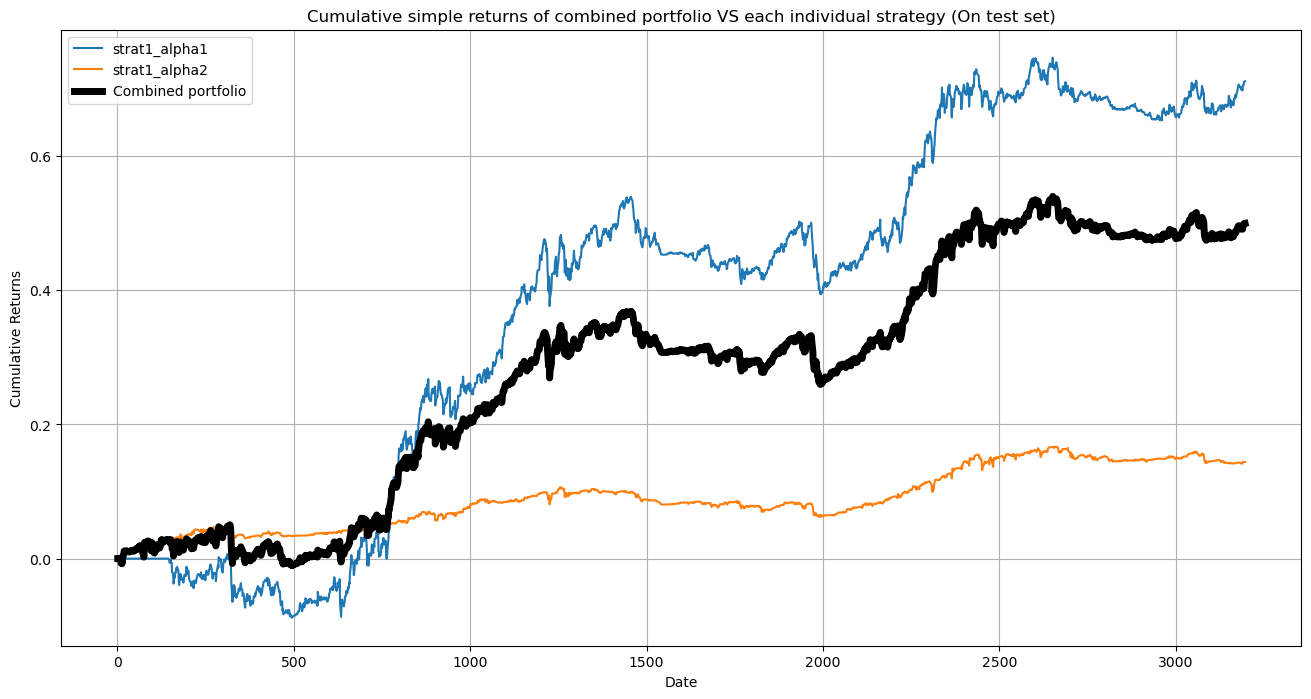

In [13]:
# Plot cumulative simple returns of the strategies vs an equally weighted portfolio of those strategies

plt.figure(figsize=(16,8))
plt.grid()

plt.plot(rets.index, np.nancumsum(rets.iloc[:, 0]),label='strat1_alpha1')
plt.plot(rets.index, np.nancumsum(rets.iloc[:, 3]),label='strat1_alpha2')

plt.plot(rets.index, np.nancumsum(rets['aggregated_weighted_rets']),lw=5, label='Combined portfolio', color='black')

plt.title('Cumulative simple returns of combined portfolio VS each individual strategy (On test set)')
#plt.legend()

plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()

## Equity curve of the portfolio vs benchmark (Buy&Hold SPY ETF) 

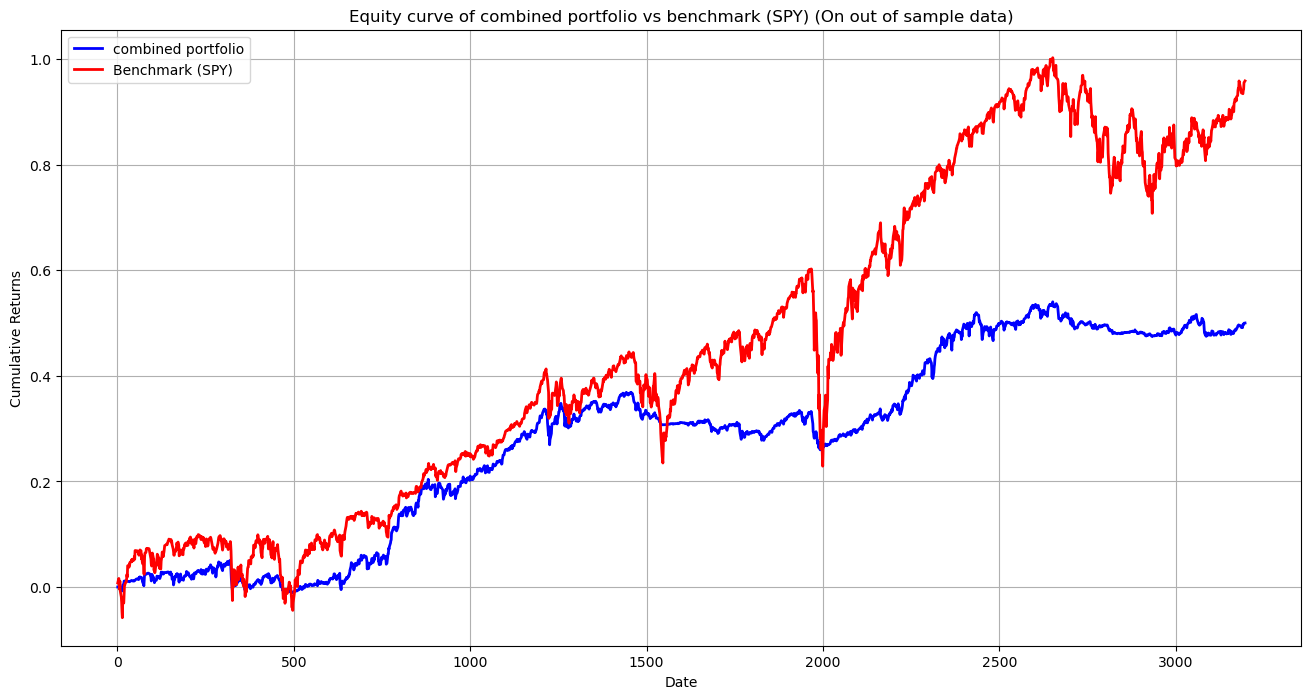

In [14]:
plt.figure(figsize=(16,8))

# Plot equity curve of the combined portfolio
plt.plot(rets.index,np.nancumsum(unr_portfolio), lw=2, color='blue', label='combined portfolio')

# Plot equity curve of buy & hold spy
plt.plot(rets.index,np.nancumsum(bench_rets), lw=2, color='red', label='Benchmark (SPY)')

plt.title('Equity curve of combined portfolio vs benchmark (SPY) (On out of sample data)')

plt.grid()
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()

## Daily returns of the portfolio 

Text(0, 0.5, 'Returns')

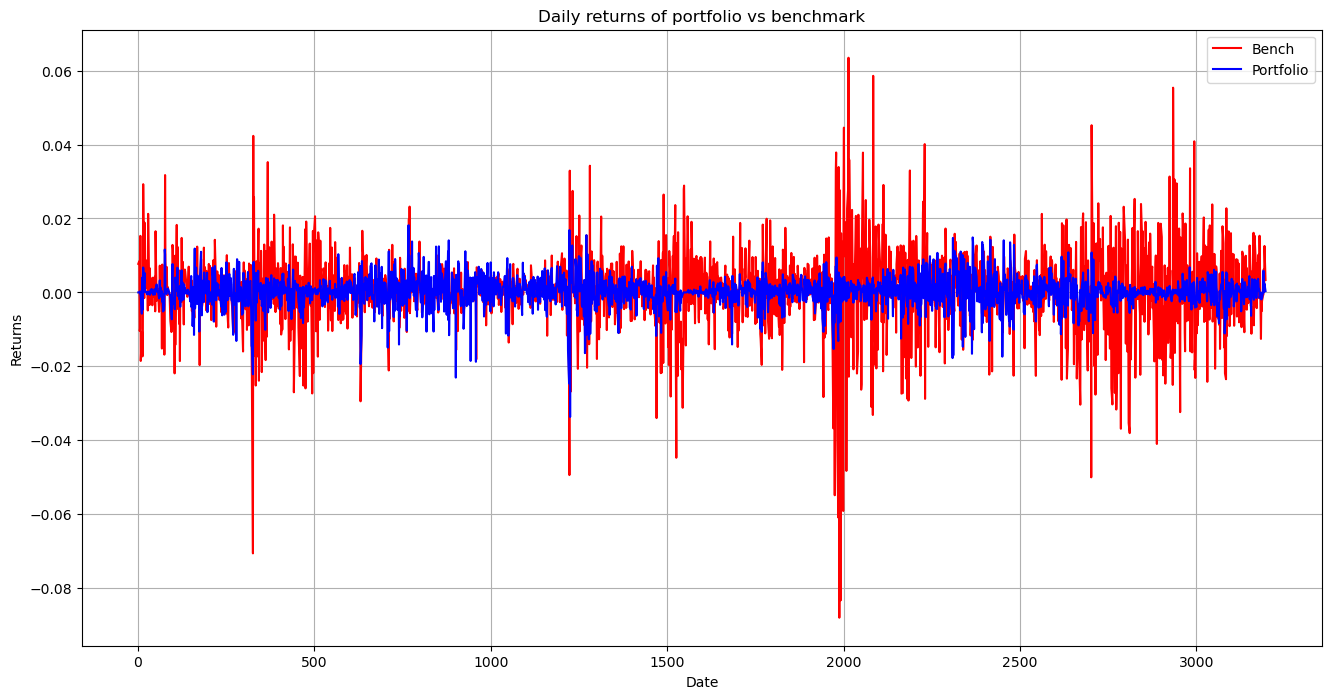

In [15]:
plt.figure(figsize=(16,8))
plt.grid()

#plt.plot(xlk.rets, label='Benchmark (XLK etf)', color='red')
#plt.plot(rets.index[split_point:],unr_bench_oos, label='Bench', color='red')
#plt.plot(rets.index[split_point:],unr_portfolio_oos, label='Portfolio', color='blue')

plt.plot(rets.index,bench_rets, label='Bench', color='red')
plt.plot(rets.index,unr_portfolio, label='Portfolio', color='blue')



plt.title('Daily returns of portfolio vs benchmark')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Returns')

# Conclusion

Even though we benefit from diversification by trading both alphas as a portfolio, it was just an illustration of what can be done. Indeed a lot more diversification is required to attain a very robust portfolio uncorrelated to the benchmark's returns.

We should continue to find and backtest new uncorrelated alphas and add them to the portfolio to increase its breadth